# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden

Last update - 8 Aug 2020

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
While testing, run US model first to baseline the latest model files. Set `us_run` to **True** For the latest stable model, checkout commit from 2 July 2020. 

For automated calculation run `rtlive-model-za.py`. Github Action `rtlive-model-za.yaml` will run automatically in on Github.

In [2]:
us_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirements.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [3]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [4]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [5]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

## Summarize Model Output

In [6]:
result = pd.DataFrame()
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

""


## Plot Model Output

In [7]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

In [8]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [9]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-08-04,20200804,79844.0,24333.0,183090.0,85986.0,9389.0,15716.0,5379.0,20270.0,97261.0,50.0,521318,https://twitter.com/DrZweliMkhize/status/12907...
2020-08-05,20200805,80400.0,25232.0,185282.0,87798.0,9625.0,17135.0,5638.0,20686.0,98031.0,50.0,529877,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806,81014.0,26123.0,187631.0,90115.0,9873.0,17803.0,5932.0,21044.0,98599.0,50.0,538184,https://twitter.com/nicd_sa/status/12914823911...
2020-08-07,20200807,81615.0,26877.0,189159.0,92444.0,10138.0,18266.0,6185.0,21315.0,99027.0,50.0,545476,https://twitter.com/nicd_sa/status/12918364670...
2020-08-08,20200808,82074.0,27742.0,190999.0,95648.0,10345.0,18734.0,6366.0,21642.0,99588.0,50.0,553188,https://twitter.com/nicd_sa/status/12921773959...


In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-08-04,20200804,3078202.0,363751,NaN,NaN,NaN,8884,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/04/update-...
2020-08-05,20200805,3113191.0,377266,NaN,NaN,NaN,9298,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/05/update-...
2020-08-06,20200806,3149807.0,387316,NaN,NaN,NaN,9604,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/06/update-...
2020-08-07,20200807,3183658.0,394759,NaN,NaN,NaN,9909,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/07/update-...
2020-08-08,20200808,3220265.0,404568,NaN,NaN,NaN,10210,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/08/update-...


## Cleanup data

In [11]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-08-04    521318
2020-08-05    529877
2020-08-06    538184
2020-08-07    545476
2020-08-08    553188
Name: cases, Length: 155, dtype: int64

In [12]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-08-08 00:00:00'))

In [13]:
idx = pd.date_range(casezero, caselast)

In [14]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-08-04    3078202.0
2020-08-05    3113191.0
2020-08-06    3149807.0
2020-08-07    3183658.0
2020-08-08    3220265.0
Name: tests, Length: 162, dtype: float64

In [15]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-08-04    3078202.0
2020-08-05    3113191.0
2020-08-06    3149807.0
2020-08-07    3183658.0
2020-08-08    3220265.0
Name: tests, Length: 153, dtype: float64

In [16]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-08-04,521318.0,3078202.0
2020-08-05,529877.0,3113191.0
2020-08-06,538184.0,3149807.0


In [17]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [18]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-08-04,521318.0,3078202.0
2020-08-05,529877.0,3113191.0
2020-08-06,538184.0,3149807.0
2020-08-07,545476.0,3183658.0


In [19]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-08-04,521318.0,3078202.0
2020-08-05,529877.0,3113191.0
2020-08-06,538184.0,3149807.0
2020-08-07,545476.0,3183658.0


In [20]:
# Add delta columns for models
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-08-04,521318.0,3078202.0,4456.0,19507.0
2020-08-05,529877.0,3113191.0,8559.0,34989.0
2020-08-06,538184.0,3149807.0,8307.0,36616.0
2020-08-07,545476.0,3183658.0,7292.0,33851.0


In [21]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-08-04,521318.0,3078202.0,4456.0,19507.0
2020-08-05,529877.0,3113191.0,8559.0,34989.0
2020-08-06,538184.0,3149807.0,8307.0,36616.0
2020-08-07,545476.0,3183658.0,7292.0,33851.0


## Calculate Rt

In [22]:
region = 'Total RSA'

In [23]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [10:13<00:00,  5.87draws/s]


## Show results

In [24]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 398.23it/s]


In [25]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-30,0.946374,0.938348,0.761625,1.076356,6644.237320,8739.512068,8479.075050,11046.0,44886.0
2020-07-31,0.946394,0.938893,0.786517,1.115333,6591.711977,8658.856918,9147.403880,11014.0,41486.0
2020-08-01,0.947777,0.942203,0.741965,1.081802,6542.132961,8576.459254,8203.494980,10107.0,42450.0
2020-08-02,0.946213,0.939548,0.762924,1.104913,6495.715387,8493.198707,8115.194708,8195.0,34794.0
2020-08-03,0.945573,0.941364,0.768022,1.120913,6454.332039,8409.908581,8453.432520,5377.0,21916.0
2020-08-04,0.944656,0.942247,0.770377,1.133932,6416.942069,8327.351445,7870.621793,4456.0,19507.0
2020-08-05,0.945192,0.936937,0.760534,1.128922,6382.447995,8246.322703,8428.413646,8559.0,34989.0
2020-08-06,0.945671,0.941075,0.724197,1.098721,6351.406518,8167.556078,7816.775815,8307.0,36616.0
2020-08-07,0.945363,0.937208,0.749506,1.127982,6325.183451,8091.524912,7422.146165,7292.0,33851.0


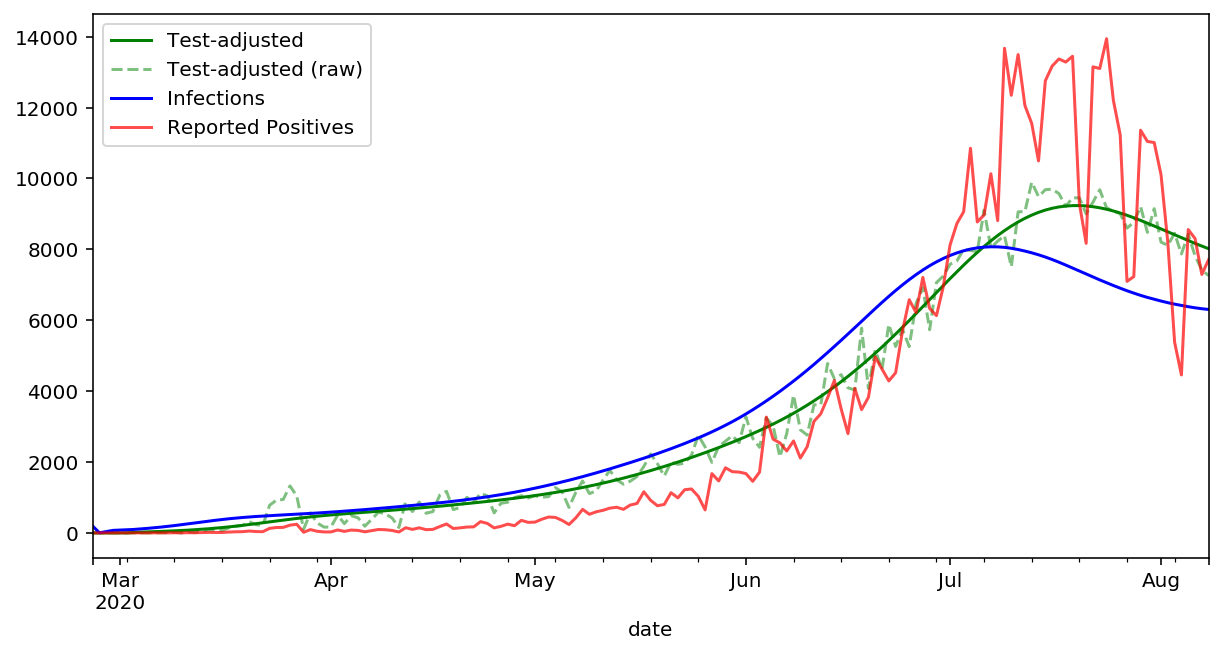

In [26]:
plot_results()

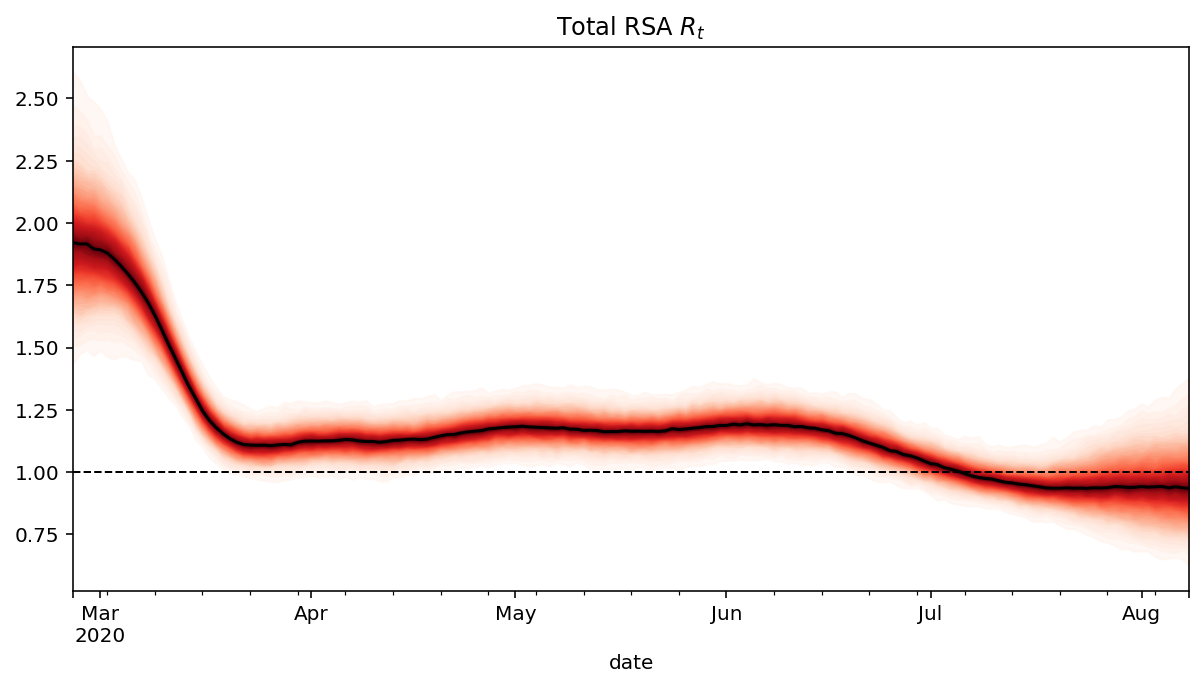

In [27]:
plot_rt()

In [28]:
export_results = result[['median','upper_80','lower_80','infections','test_adjusted_positive']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80','infections':'Infections','test_adjusted_positive':'Adjusted_Postive'})
export_results.tail()

,Median,High_80,Low_80,Infections,Adjusted_Postive
date,,,,,
2020-08-04,0.942247,1.133932,0.770377,6416.942069,8327.351445
2020-08-05,0.936937,1.128922,0.760534,6382.447995,8246.322703
2020-08-06,0.941075,1.098721,0.724197,6351.406518,8167.556078
2020-08-07,0.937208,1.127982,0.749506,6325.183451,8091.524912
2020-08-08,0.934245,1.121333,0.737677,6304.766473,8018.524981


## Export results

In [29]:
#export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')
export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')